In [1]:
import anndata as ad
import squidpy as sq
import cellcharter as cc
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


In [2]:
path = '/work/rwth1209/dana_projects/test_new_imputation_tools/enVI/ref/complete_spatial_vk12_coarse_annotation.h5ad'

In [3]:
adata = sc.read_h5ad(f"{path}")
adata

AnnData object with n_obs × n_vars = 217184 × 500
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'n_counts', 'leiden_0_5', 'leiden_1', 'leiden_1_5', 'tacco', 'cell_type'
    var: 'mean', 'std'
    uns: 'cell_type_colors', 'leiden', 'leiden_0_5_colors', 'leiden_1_5_colors', 'leiden_1_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'tacco_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'blank_genes', 'spatial', 'tacco'
    varm: 'PCs', 'tacco'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
sc.pp.filter_cells(adata, min_counts=1)

In [5]:
scvi.settings.seed = 12345
scvi.model.SCVI.setup_anndata(
    adata, 
    layer="counts", batch_key='region')

Global seed set to 12345
/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
model = scvi.model.SCVI(adata)

In [7]:
model.train(early_stopping=True, enable_progress_bar=True)

/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/xu262605/anaconda3/envs/cellcharter/lib/python ...
  rank_zero_warn(
/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/xu262605/anaconda3/envs/cellcharter/lib/python ...
  rank_zero_warn(


Epoch 1/92:   0%|          | 0/92 [00:00<?, ?it/s]

/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 92/92: 100%|██████████| 92/92 [18:50<00:00, 12.28s/it, loss=120, v_num=1]


In [8]:
adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)

In [9]:
sq.gr.spatial_neighbors(adata, coord_type='generic', delaunay=True, spatial_key='spatial')
cc.gr.remove_long_links(adata)

In [10]:
cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter')

100%|██████████| 4/4 [00:00<00:00, 13.56it/s]


In [11]:
gmm = cc.tl.Cluster(n_clusters=5, random_state=12345)

In [12]:
gmm.fit(adata, use_rep='X_cellcharter')
adata.obs['spatial_cluster_5'] = gmm.predict(adata, use_rep='X_cellcharter')

/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/xu262605/anaconda3/envs/cellcharter/lib/python ...
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.54it/s]


/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


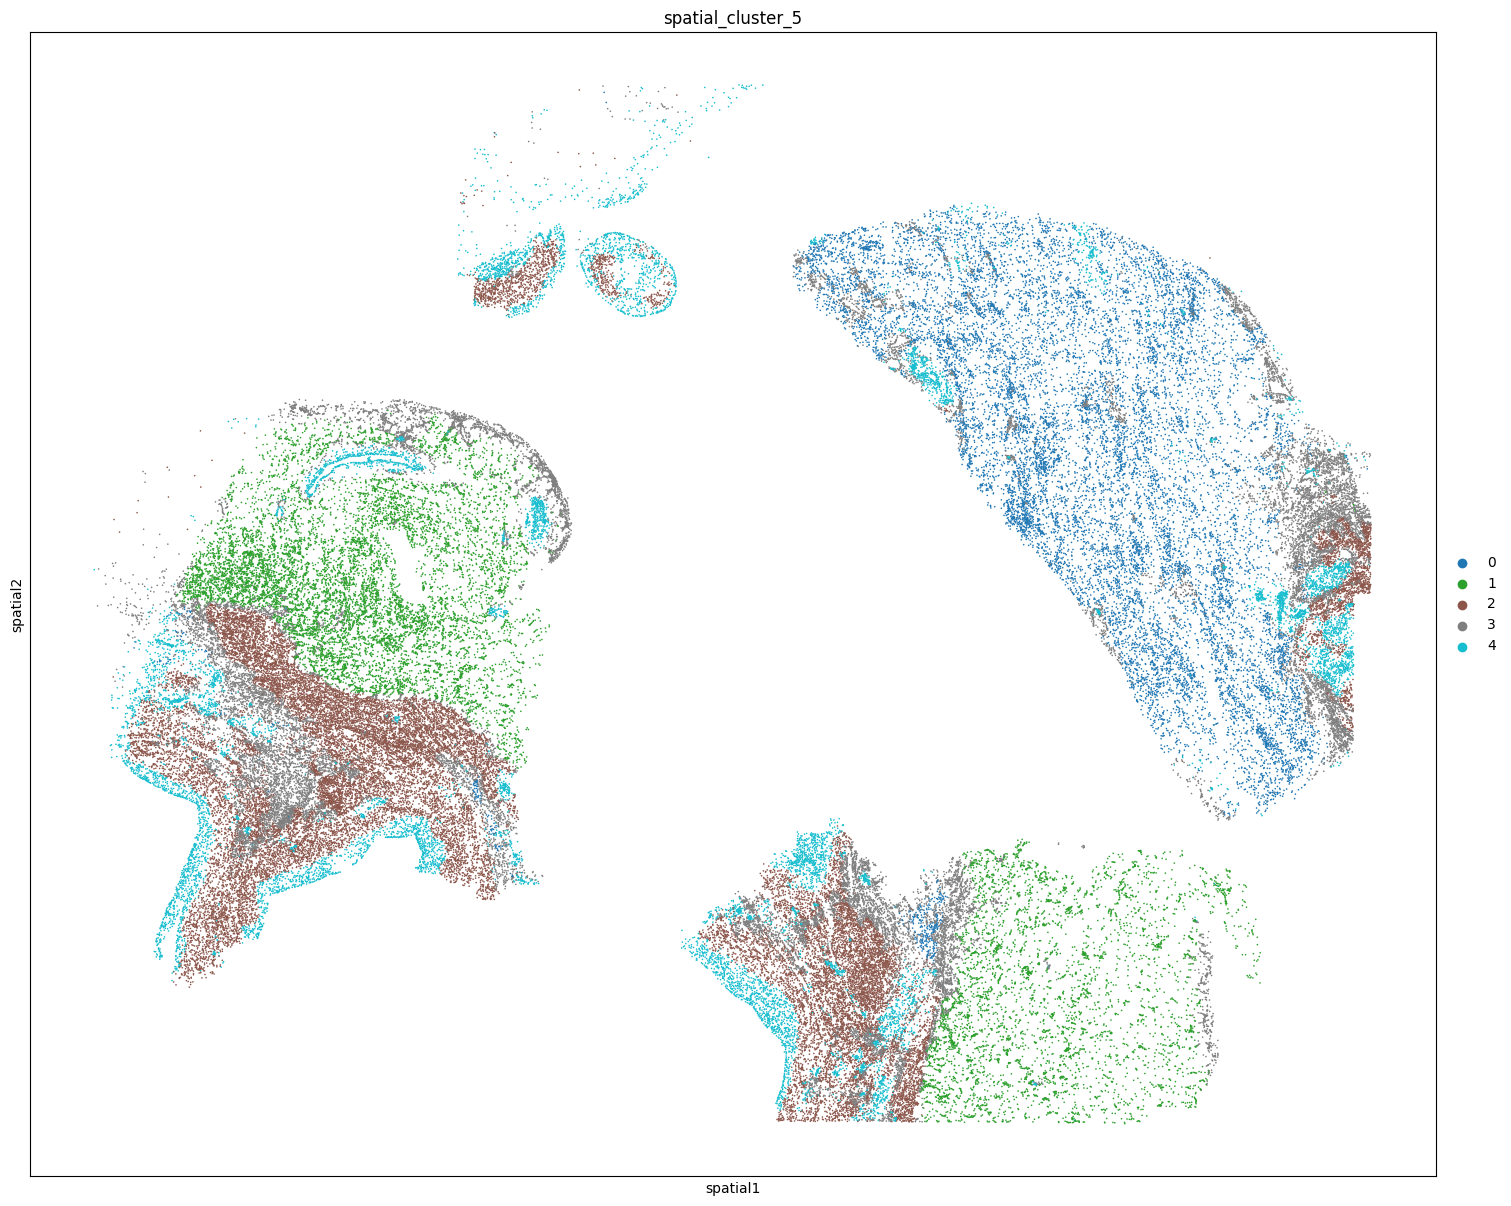

In [13]:
sq.pl.spatial_scatter(
    adata, 
    color=['spatial_cluster_5'], 
    #library_key='fov',  
    size=10, 
    img=None,
    spatial_key='spatial',
    palette='tab10',
    figsize=(15,15),
    ncols=1)

/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/xu262605/anaconda3/envs/cellcharter/lib/python ...
  rank_zero_warn(
/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/xu262605/anaconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. 

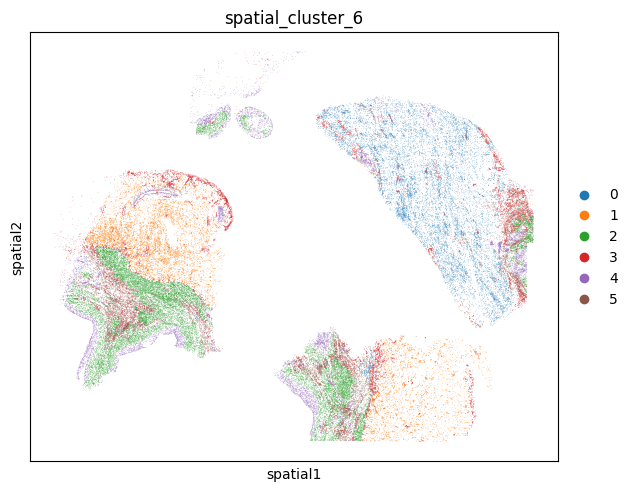

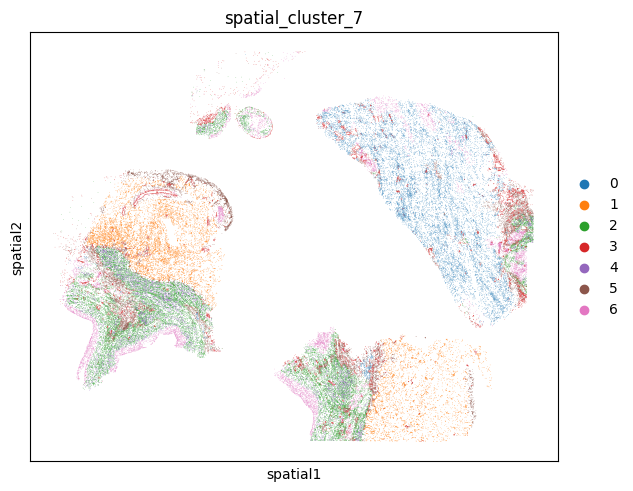

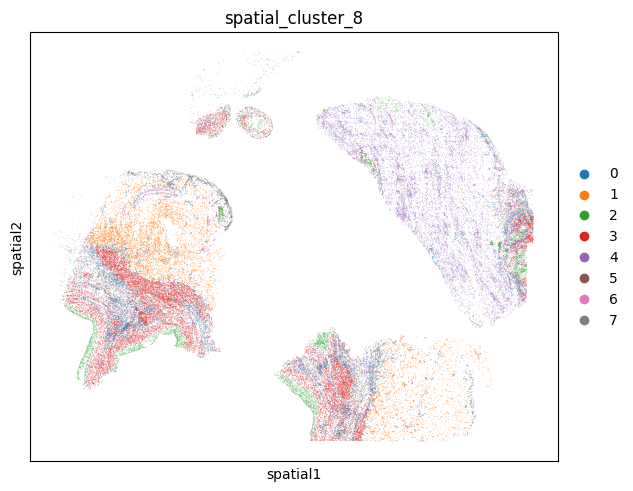

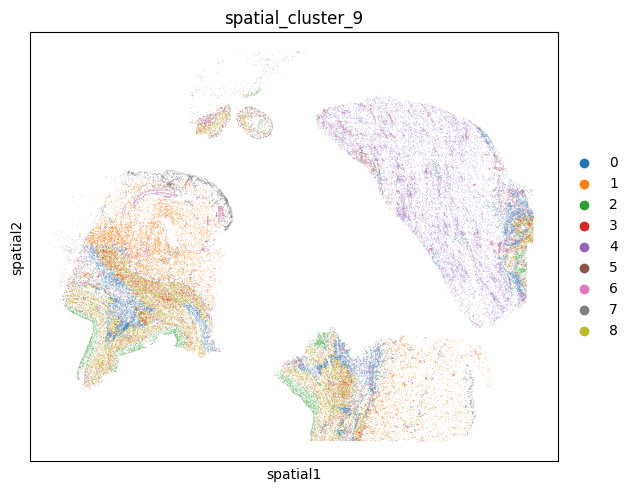

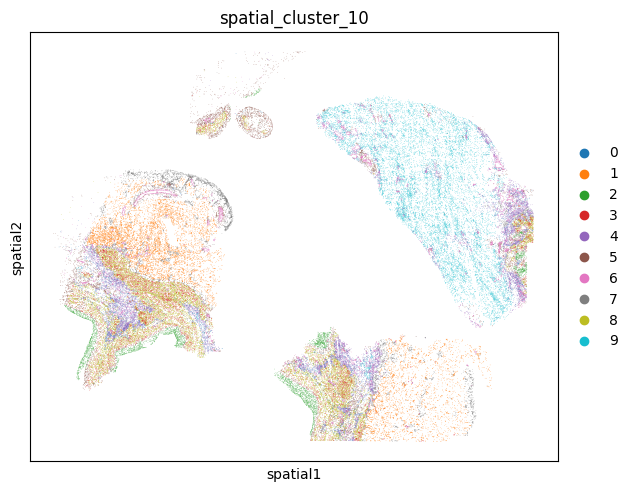

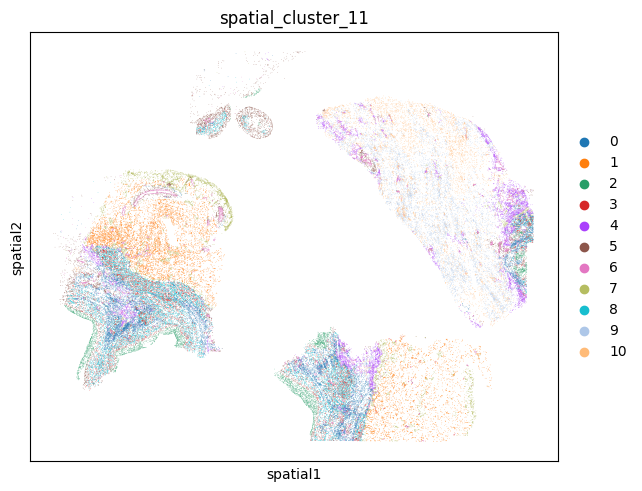

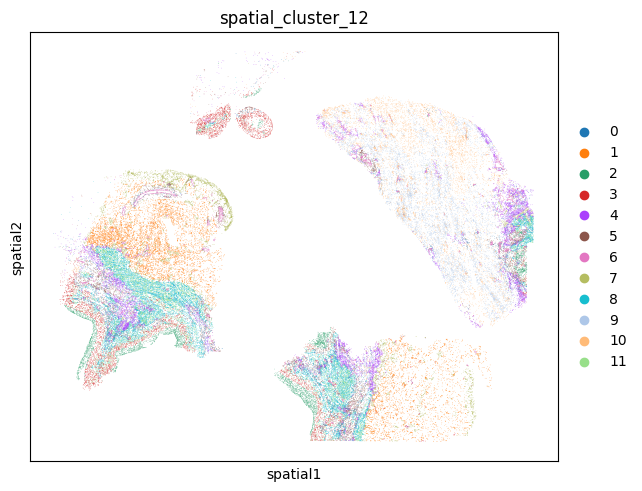

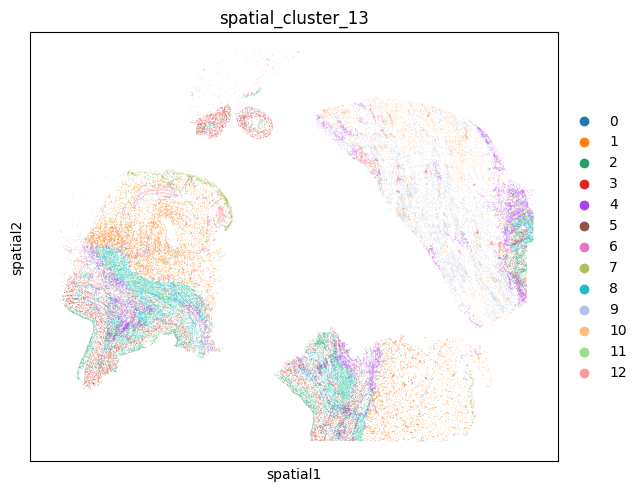

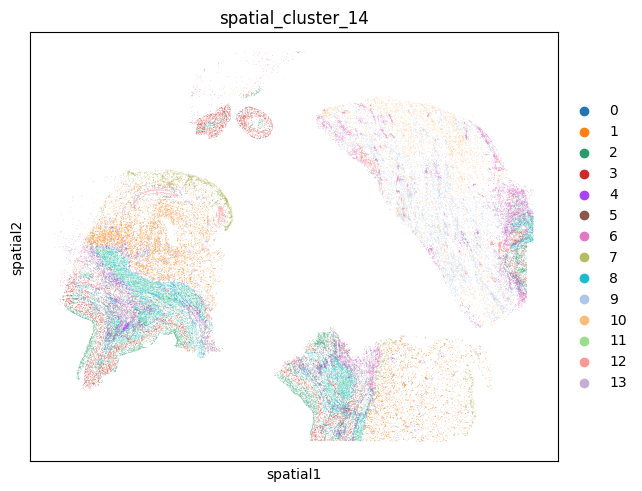

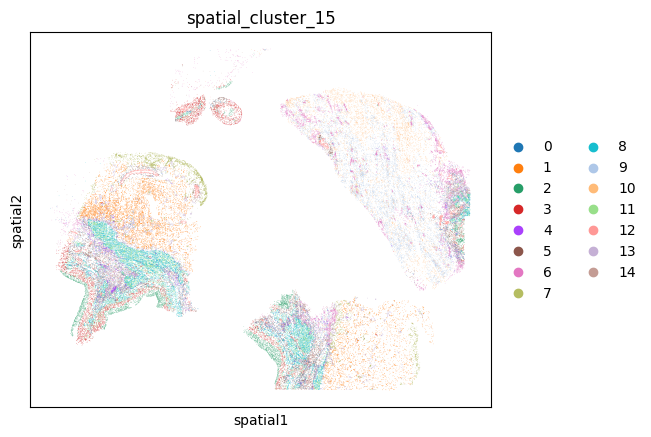

In [14]:
for i in range(6,16):
    gmm = cc.tl.Cluster(n_clusters=i, random_state=12345)
    gmm.fit(adata, use_rep='X_cellcharter')
    adata.obs[f'spatial_cluster_{i}'] = gmm.predict(adata, use_rep='X_cellcharter')
    sq.pl.spatial_scatter(adata, color=f'spatial_cluster_{i}', img=None, size=8, ncols=2)

In [15]:
adata

AnnData object with n_obs × n_vars = 87215 × 500
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'n_counts', 'leiden_0_5', 'leiden_1', 'leiden_1_5', 'tacco', 'cell_type', '_scvi_batch', '_scvi_labels', 'spatial_cluster_5', 'spatial_cluster_6', 'spatial_cluster_7', 'spatial_cluster_8', 'spatial_cluster_9', 'spatial_cluster_10', 'spatial_cluster_11', 'spatial_cluster_12', 'spatial_cluster_13', 'spatial_cluster_14', 'spatial_cluster_15'
    var: 'mean', 'std'
    uns: 'leiden', 'leiden_1_5_colors', 'leiden_1_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'tacco_colors', 'umap', '_scvi_uuid', '_scvi_manager_uuid', 'spatial_neighbors', '_cellcharter', 'spatial_cluster_5_colors', 'spatial_clu

In [16]:
adata.write('cellcharter_15_clusters.h5ad')

In [24]:
adata

AnnData object with n_obs × n_vars = 87215 × 500
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'n_counts', 'leiden_0_5', 'leiden_1', 'leiden_1_5', 'tacco', 'cell_type', '_scvi_batch', '_scvi_labels', 'spatial_cluster_5', 'spatial_cluster_6', 'spatial_cluster_7', 'spatial_cluster_8', 'spatial_cluster_9', 'spatial_cluster_10', 'spatial_cluster_11', 'spatial_cluster_12', 'spatial_cluster_13', 'spatial_cluster_14', 'spatial_cluster_15'
    var: 'mean', 'std'
    uns: 'leiden', 'leiden_1_5_colors', 'leiden_1_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'tacco_colors', 'umap', '_scvi_uuid', '_scvi_manager_uuid', 'spatial_neighbors', '_cellcharter', 'spatial_cluster_5_colors', 'spatial_clu

In [29]:
obs_df = adata.obs

In [31]:
obs_df.to_csv('obs_data_15_clusters.csv')